In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import fowlkes_mallows_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import statsmodels.api as sm
import scipy as sc
from scipy.stats import mode
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import Normalizer,StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import gensim
import re
import gensim.downloader as model_api
from sklearn.model_selection import train_test_split

/Users/Coding/mambaforge/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
csl = pd.read_csv('/Users/Coding/Desktop/School/Final Project/Data/CSL.csv')
csl

,Date,Name,Review,Rating
0,a month ago,Catherine Daigneault,(Translated by Google) The vet was very friend...,4 stars
1,a month ago,gilles paquette,NaN,4 stars
2,a month ago,Sherika Duncan,Great hospital for my little doggies. Friendly...,5 stars
3,2 months ago,susan montgrain,They were very efficient and called a taxi for...,5 stars
4,3 months ago,Maya D.,NaN,5 stars
...,...,...,...,...
98,4 years ago,User Name,Toke an appointment still waited over an hour ...,1 star
99,5 years ago,Spaghetti Sandwich,This clinic is the best. They are honest and c...,5 stars
100,6 years ago,Florent Gatore,NaN,5 stars
101,7 years ago,john ben,"Best Vets in the City ,thank you for all you do .",5 stars


In [3]:
csl = csl.dropna()
csl = csl.drop(['Date', 'Name'], axis = 1)

In [4]:
csl.Rating = csl.Rating.str.replace('5 stars', '5')
csl.Rating = csl.Rating.str.replace('4 stars', '4')
csl.Rating = csl.Rating.str.replace('3 stars', '3')
csl.Rating = csl.Rating.str.replace('2 stars', '2')
csl.Rating = csl.Rating.str.replace('1 star', '1')
csl.Rating = csl.Rating.astype(int)
csl

,Review,Rating
0,(Translated by Google) The vet was very friend...,4
2,Great hospital for my little doggies. Friendly...,5
3,They were very efficient and called a taxi for...,5
5,(Translated by Google) Perfect\n\n(Original)\n...,5
7,"A bit pricey, but worth it. The service is exc...",5
8,(Translated by Google) A very bad experience w...,1
9,Excellent quality care for our dearest furry f...,5
10,I've been taking my dogs and cats there for ma...,5
11,They staff are kind and professional. They see...,4
12,They’re not pigs looking for the dollar they a...,5


In [5]:
csl.Review = csl.Review.astype(str)
csl.Review = [x.lower() for x in csl.Review]

In [6]:
words = csl.Review.str.split()
words = pd.DataFrame(words.tolist())

In [7]:
replaceDict = dict({
'{':" ", '}':" ", ',':"", '.':" ", '!':" ", '\\':" ", '/':" ", '$':" ", '%':" ",
'^':" ", '?':" ", '\'':" ", '"':" ", '(':" ", ')':" ", '*':" ", '+':" ", '-':" ",
'=':" ", ':':" ", ';':" ", ']':" ", '[':" ", '`':" ", '~':" ",
})

rep = dict((re.escape(k), v) for k, v in replaceDict.items())
pattern = re.compile("|".join(rep.keys()))

def replacer(text):
    return rep[re.escape(text.group(0))]

words = csl.Review.str.replace(pattern, replacer).str.lower().str.split()
words = pd.DataFrame(words.tolist())
words

,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,58
0,translated,by,google,the,vet,was,very,friendly,and,gave,...,None,None,None,None,None,None,None,None,None,None
1,great,hospital,for,my,little,doggies,friendly,staff,None,None,...,None,None,None,None,None,None,None,None,None,None
2,they,were,very,efficient,and,called,a,taxi,for,me,...,None,None,None,None,None,None,None,None,None,None
3,translated,by,google,perfect,original,parfait,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,a,bit,pricey,but,worth,it,the,service,is,excellent,...,None,None,None,None,None,None,None,None,None,None
5,translated,by,google,a,very,bad,experience,with,this,veterinary,...,None,None,None,None,None,None,None,None,None,None
6,excellent,quality,care,for,our,dearest,furry,friend,None,None,...,None,None,None,None,None,None,None,None,None,None
7,i,ve,been,taking,my,dogs,and,cats,there,for,...,None,None,None,None,None,None,None,None,None,None
8,they,staff,are,kind,and,professional,they,seem,competent,although,...,None,None,None,None,None,None,None,None,None,None
9,they’re,not,pigs,looking,for,the,dollar,they,actually,care,...,None,None,None,None,None,None,None,None,None,None


In [8]:
word_vectors = model_api.load("glove-wiki-gigaword-200")

words.columns = words.columns.astype(str)

def soft_get(w):
    try:
        return word_vectors[w]
    except KeyError:
        return np.zeros(word_vectors.vector_size)
    
def map_vectors(row):
    try:
        return np.sum(
            row.loc[row.notna()].apply(soft_get)
        )
    except:
        return np.zeros(word_vectors.vector_size)
    
emb = pd.DataFrame(words.apply(map_vectors, axis=1))
emb.columns = ['C']
emb = pd.DataFrame(np.array(emb.C.apply(pd.Series)))
emb

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,9.364347,9.403784,-1.248119,-12.195782,-1.444399,2.921477,-13.953717,-2.445169,7.121347,0.169577,...,-1.778706,0.625988,-4.727147,1.961886,8.227275,4.131157,-6.737926,4.007859,0.641082,6.615012
1,1.229087,0.461956,0.636830,-1.218392,0.127879,-1.280312,-2.529714,-0.115201,0.500415,3.110276,...,-0.185107,1.588760,-1.018827,0.147741,1.381322,0.609922,0.019847,0.568584,-0.040882,1.573952
2,3.198035,3.299149,-4.457178,-3.433155,-1.494824,-0.933646,-5.470298,-1.156937,2.393952,2.807145,...,-3.000157,0.891340,-3.496034,1.221153,4.180867,0.516395,-1.616067,2.677615,-2.234023,3.253641
3,-1.029880,0.384984,1.131037,-1.255020,2.732536,-1.156523,-1.363980,-0.929714,0.575974,-2.612410,...,-0.733437,-1.306505,1.413796,-1.359370,1.203401,-1.465090,-0.611497,1.064532,0.992503,-0.146533
4,10.595858,9.748671,0.513972,-10.145418,1.834121,-1.024057,-14.898235,4.765719,-0.794359,8.086125,...,-6.024992,2.833158,-4.216172,4.302014,1.914298,-1.445772,-4.215602,3.648151,-3.864186,5.653607
5,4.963820,3.320678,0.939660,-10.456343,0.764695,-2.194953,-17.158165,-1.019876,3.089102,12.019873,...,-5.136393,-0.770966,-1.988560,1.373508,4.462521,-0.439744,0.442731,5.671195,-4.097010,1.546307
6,2.158380,1.828920,-0.928360,-1.059775,-1.138658,-1.005259,-1.269018,1.503163,-0.346500,2.910122,...,-0.139239,-1.501067,-1.058661,1.922050,-0.862962,-2.382270,-0.687880,0.677358,-0.831586,1.762558
7,3.078972,4.717328,-2.256031,-2.480550,-2.638308,-0.092555,-13.935158,3.085490,0.634512,11.159107,...,-4.375726,-0.439319,-3.816763,2.783129,2.998411,-1.163542,1.202250,1.925334,-2.307639,5.887470
8,10.159943,10.129099,-4.935474,-9.399589,-0.714330,1.439987,-19.888172,3.622644,7.141892,9.805968,...,-9.443777,1.537208,-3.778034,5.263880,6.270770,-2.370409,0.230174,8.068794,-3.247564,4.354807
9,2.922538,2.531349,-0.866921,-1.437650,0.271129,0.403572,-8.168388,0.802906,-1.204642,9.247187,...,-4.068285,0.188060,-1.750679,3.483145,-0.266241,-1.318155,-2.150212,2.128718,-3.965180,4.203909


In [9]:
emb = emb.fillna(0)

In [10]:
X = Normalizer().fit_transform(emb) #Normalizer gives better score
sgdr = SGDRegressor()
sgdr.fit(X, csl['Rating'])
csl['gensim'] = sgdr.predict(X)
sgdr.score(X, csl['Rating']) #not very good

-0.01722163455399217

In [12]:
COMPRESSED_SIZE = 50

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(csl['Review'])

Xd = X.toarray()
Xd = PCA(COMPRESSED_SIZE).fit(Xd.T).components_.T
Xd = sm.add_constant(Xd)

In [13]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(emb)
    distortions.append(kmeanModel.inertia_)

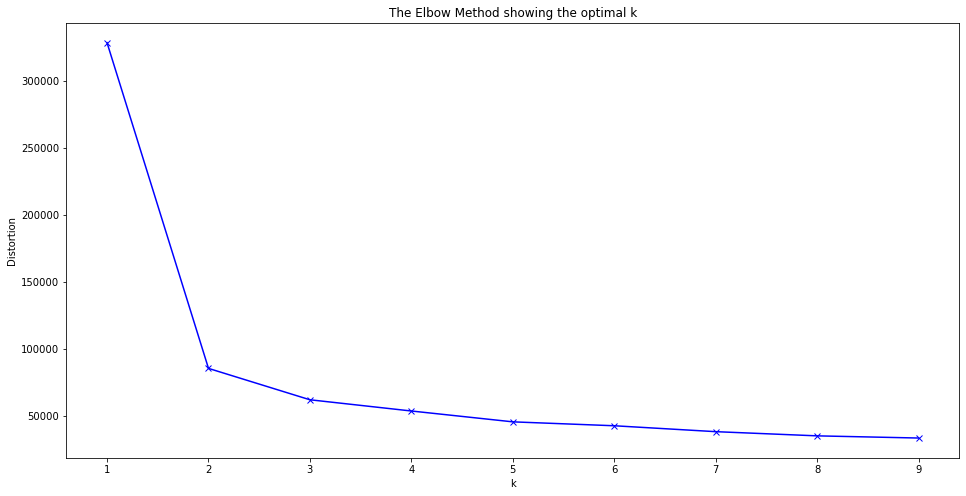

In [14]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show() #3 clusters is the way to go

In [15]:
k = 3
model = KMeans(n_clusters = k, init = 'k-means++', max_iter = 100, n_init = 1)
model.fit(X)
clusters = model.predict(X)

In [16]:
y = np.array(csl['Rating'])
labels = np.zeros_like(clusters)
for i in range(5):
    mask = (clusters == i)
    labels[clusters == i] = mode(y[clusters == i])[0]

In [17]:
csl['kmeans_tfidf'] = labels
csl

,Review,Rating,gensim,kmeans_tfidf
0,(translated by google) the vet was very friend...,4,4.392958,5
2,great hospital for my little doggies. friendly...,5,4.521332,5
3,they were very efficient and called a taxi for...,5,4.394961,5
5,(translated by google) perfect\n\n(original)\n...,5,3.787702,5
7,"a bit pricey, but worth it. the service is exc...",5,4.468556,5
8,(translated by google) a very bad experience w...,1,4.442973,5
9,excellent quality care for our dearest furry f...,5,4.397892,5
10,i've been taking my dogs and cats there for ma...,5,4.499114,5
11,they staff are kind and professional. they see...,4,4.450792,5
12,they’re not pigs looking for the dollar they a...,5,4.439262,5


In [18]:
fowlkes_mallows_score(csl.kmeans_tfidf, y) 

0.7676142911251093

In [19]:
accuracy_score(csl.kmeans_tfidf, y)

0.7586206896551724

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [22]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test))) #best

Accuracy of logistic regression classifier on test set: 0.78


In [23]:
fowlkes_mallows_score(y_pred, y_test)

0.7796429549831781